In [65]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    cross_val_score,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.base import clone

##

# Methodology

## Data Preprocessing

The Titantic dataset was preprocessed to enhance its suitability for statistical modeling and to reduce noise and redundancy. Identifer features lacking predictive relevance, such as passenger identifers or ticket numbers, were removed prior to analysis. Missing values in numeric features were imputed using the median, whereas missing categorical variables were imputed using the mode. Categorical features were encoded as dummy variables to use in linear modeling frameworks. 

To further reduce redundancy and limit multicollinearity, several features were evaluated and pruned. For example, family-related variables were replaced with a single family size variable. This step is necessary for Linear Discriminant Analysis (LDA) since this method relies on covariance estimation and is sensitive to highy correlated inputs. 

## Model Selection

### Linear Discriminant Analysis

Linear Discriminant Analysis (LDA) was chosen because it remains highly effective for structured data while remaining easy to interpret. This model functions by identifying the specific factors that drive group differences, a principle orginally established by Fisher (1936) through maximization of between-class variance. This approach provides a principled way to reduce dimensionality and perform classification, provided the data maintains a consistent covariance structure across classes. 

In this project, LDA was applied to applied to distinguish between survivors and non-survivors by learning a discriminant direction that highlights the systematic variations in passenger profiles. Since the model is built on a linear framework, it provides a transparent lens through which we can evaluate the importance of each feature which contributed to survival outcomes. LDA offeres a balace of simplicity and effectivness often preforming competitively with more complex models (Hastie et al., 2009).

Beyond predictive performance, LDA was chosen for its interpretability. The estimated discriminant coefficients act as a direct measure of feature influence, indicating both the direction and magnitude of each variable’s contribution to class separation. This property is especially valuable in applied settings, where understanding why predictions are made is as important as predictive accuracy. In this project, coefficient-based interpretation allowed meaningful insights into the relative importance of demographic, socioeconomic, and cabin-related features in determining survival outcomes.



# Experiment

## Expermential Design
The experimental evaluation of LDA model was designed to assess both predictive erformance and model stabiliy while avoiding data leackage. Following preprocessing, the dataset was partitioned into training and test sets using a 75%-25% stratified split to preserve the orginal propotion of survivors and non-survivors. All resampleing, model fitting, hyperparamater tuning, and feature analysis were conducted exclusively on the training set, while the test set was reserved for a single final evaluation.

Model performance on the training data was estimated using repeated stratified k-fold cross-validation. This ensures that each fold reflected the class didtrubuation of the full dataset, while repetion reduced variance in performance estimates across data parttions. 




## Results and Analysis

## Discussion

## References

Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. Annals of Eugenics, 7(2), 179–188.


Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (3rd ed.). O’Reilly Media.

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Springer Science & Business Media.

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning with Applications in R (2nd ed.). Springer.

<!-- Kohavi, R. (1995). A study of cross-validation and bootstrap for accuracy estimation and model selection. Proceedings of the 14th International Joint Conference on Artificial Intelligence.

Kuhn, M., & Johnson, K. (2013). Applied Predictive Modeling. Springer.

Ledoit, O., & Wolf, M. (2004). A well-conditioned estimator for large-dimensional covariance matrices. Journal of Multivariate Analysis, 88(2), 365–411.

Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830. -->


In [66]:
# -------------------------
# 1) Load + preprocess data
# -------------------------
df = pd.read_csv("data/titanic_augmented.csv")

drop_cols = ["PassengerId", "Name", "Ticket", "Cabin", "booking_reference", "service_id", "title",
             "SibSp", "Parch", "is_alone", "fare_per_person", "age_fare_ratio", "cabin_room_number",
             "name_length", "name_word_count"
             ]
df = df.drop(columns=drop_cols)

# Impute missing values
df["Age"] = df["Age"].fillna(df.groupby("Pclass")["Age"].transform("median")) # missing age filled by median of the Pclass age
                             
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# One-hot encode categoricals
df = pd.get_dummies(
    df,
    columns=["Sex", "Embarked", "title_group", "cabin_deck"],
    drop_first=True
)

X = df.drop(columns=["Survived"])
y = df["Survived"]


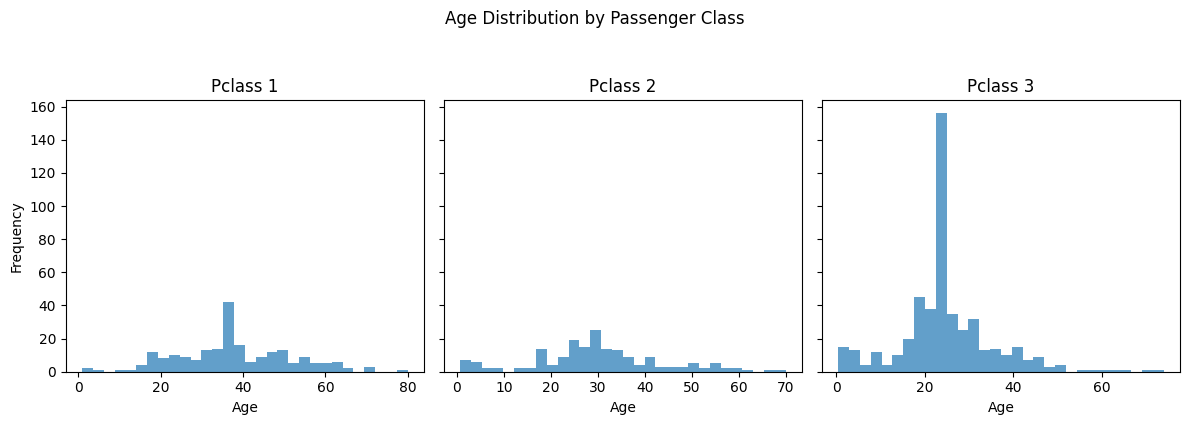

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, pclass in enumerate(sorted(df["Pclass"].unique())):
    axes[i].hist(
        df[df["Pclass"] == pclass]["Age"],
        bins=30,
        alpha=0.7
    )
    axes[i].set_title(f"Pclass {pclass}")
    axes[i].set_xlabel("Age")
    if i == 0:
        axes[i].set_ylabel("Frequency")

fig.suptitle("Age Distribution by Passenger Class", y=1.05)
plt.tight_layout()
plt.show()
df.groupby("Pclass")["Age"].median()

In [68]:
# -------------------------
# 2) Train/Test split (25% test)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [69]:
# -------------------------
# 3) Resampling setup (CV on TRAIN only)
# -------------------------
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

=== Baseline LDA (TRAIN CV) ===
CV Accuracy: mean=0.8234, std=0.0440

=== Baseline LDA (TEST holdout) ===
Test Accuracy: 0.8386
Test MSE:      0.1614
Confusion matrix:
 [[120  17]
 [ 19  67]]

=== Top 15 Features (LDA Baseline) ===
                    mean_coef  mean_abs_coef  std_abs_coef
title_group_Mr      -1.848320       1.848320      0.140749
Sex_male            -1.676483       1.676483      0.173874
title_group_Miss    -1.287675       1.287675      0.185952
title_group_Mrs     -0.825364       0.825364      0.172200
Pclass              -0.720229       0.720229      0.057718
family_size         -0.533533       0.533533      0.073269
Age                 -0.514993       0.514993      0.052269
title_group_Other   -0.506572       0.506572      0.075887
cabin_deck_Unknown  -0.383500       0.383500      0.147285
Fare                 0.285911       0.285911      0.049545
cabin_score          0.239801       0.239801      0.044537
cabin_deck_D         0.222907       0.222907      0.065185
c

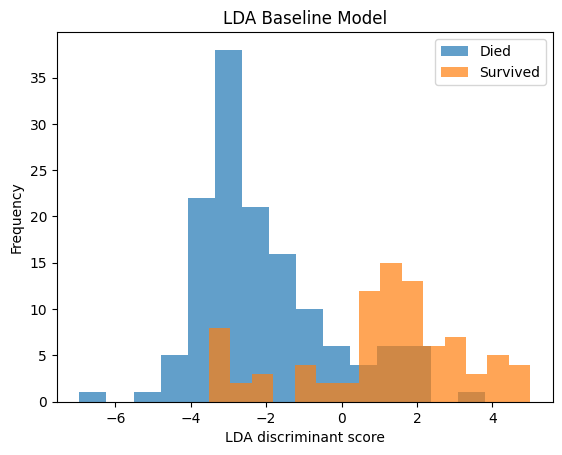

In [70]:
# -------------------------
# 4) Baseline LDA model (no tuning)
# -------------------------
baseline_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())  # default solver='svd'
])

cv_scores_baseline = cross_val_score(
    baseline_pipeline, X_train, y_train,
    cv=cv, scoring="accuracy"
)

print("=== Baseline LDA (TRAIN CV) ===")
print(f"CV Accuracy: mean={cv_scores_baseline.mean():.4f}, std={cv_scores_baseline.std():.4f}")

# Fit on TRAIN, evaluate on TEST
baseline_pipeline.fit(X_train, y_train)
y_pred_test = baseline_pipeline.predict(X_test)

print("\n=== Baseline LDA (TEST holdout) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Test MSE:      {mean_squared_error(y_test, y_pred_test):.4f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_test))

coefs_baseline = []
for tr_idx, va_idx in cv.split(X_train, y_train):
    X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    m = clone(baseline_pipeline)
    m.fit(X_tr, y_tr)
    coefs_baseline.append(m.named_steps["lda"].coef_.ravel())

coefs_baseline = np.vstack(coefs_baseline)

importance_baseline = pd.DataFrame({
    "mean_coef": np.mean(coefs_baseline, axis=0),
    "mean_abs_coef": np.mean(np.abs(coefs_baseline), axis=0),
    "std_abs_coef":  np.std(np.abs(coefs_baseline), axis=0)
}, index=X_train.columns).sort_values("mean_abs_coef", ascending=False)

print("\n=== Top 15 Features (LDA Baseline) ===")
print(importance_baseline.head(15))

lda_scores_baseline = baseline_pipeline.decision_function(X_test)

plt.figure()
plt.hist(lda_scores_baseline[y_test == 0], bins=15, alpha=0.7, label="Died")
plt.hist(lda_scores_baseline[y_test == 1], bins=15, alpha=0.7, label="Survived")
plt.xlabel("LDA discriminant score")
plt.ylabel("Frequency")
plt.title("LDA Baseline Model")
plt.legend()
plt.show()


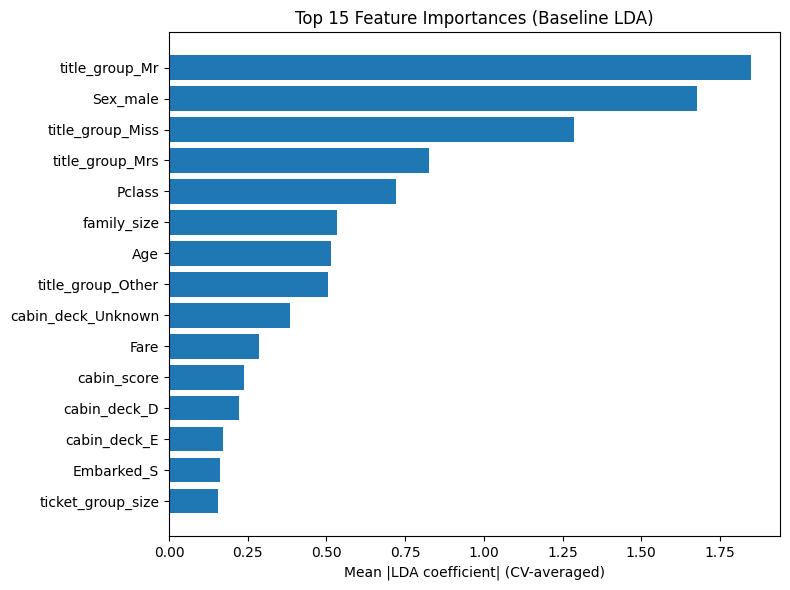

In [71]:
top_n = 15
top = importance_baseline.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top.index[::-1], top["mean_abs_coef"][::-1])
plt.xlabel("Mean |LDA coefficient| (CV-averaged)")
plt.title(f"Top {top_n} Feature Importances (Baseline LDA)")
plt.tight_layout()
plt.show()

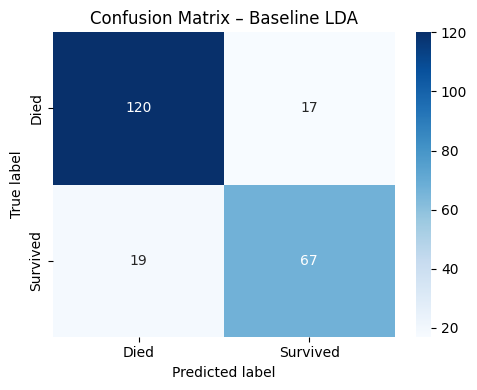

In [72]:
cm = confusion_matrix(y_test, y_pred_test)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Died", "Survived"],
    yticklabels=["Died", "Survived"]
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Baseline LDA")
plt.tight_layout()
plt.show()

In [73]:
# -------------------------
# 5) Hyperparameter tuning (TRAIN only) - solver + shrinkage
#    Note: shrinkage applies to lsqr (not svd).
# -------------------------
tuned_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])
shrink_grid = ["auto"] + list(np.linspace(0, 1, 21))
param_grid = [
    {"lda__solver": ["svd"]},  
    {"lda__solver": ["lsqr"], "lda__shrinkage": shrink_grid}
]

grid = GridSearchCV(
    tuned_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=1  # keep 1 for reliability in some notebook environments
)

grid.fit(X_train, y_train)

print("\n=== Tuned LDA (TRAIN CV via GridSearchCV) ===")
print("Best params:", grid.best_params_)
print(f"Best CV Accuracy: {grid.best_score_:.4f}")

best_model = grid.best_estimator_

# Evaluate best tuned model on TEST
y_pred_test_tuned = best_model.predict(X_test)
print("\n=== Tuned LDA (TEST holdout) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test_tuned):.4f}")
print(f"Test MSE:      {mean_squared_error(y_test, y_pred_test_tuned):.4f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_test_tuned))


=== Tuned LDA (TRAIN CV via GridSearchCV) ===
Best params: {'lda__shrinkage': 0.1, 'lda__solver': 'lsqr'}
Best CV Accuracy: 0.8264

=== Tuned LDA (TEST holdout) ===
Test Accuracy: 0.8072
Test MSE:      0.1928
Confusion matrix:
 [[117  20]
 [ 23  63]]


In [74]:
# -------------------------
# 6) Feature importance (TRAIN only) using CV-averaged |coefficients|
#    Use a stable LDA config (often shrinkage helps)
# -------------------------
importance_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(solver="lsqr", shrinkage=0.1))
])

coefs_best_tuned = []
for tr_idx, va_idx in cv.split(X_train, y_train):
    X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    m = clone(importance_pipeline)
    m.fit(X_tr, y_tr)
    coefs_best_tuned.append(m.named_steps["lda"].coef_.ravel())

coefs_best_tuned = np.vstack(coefs_best_tuned)

importance_best_tuned = pd.DataFrame({
    "mean_coef": np.mean(coefs_best_tuned, axis=0),
    "mean_abs_coef": np.mean(np.abs(coefs_best_tuned), axis=0),
    "std_abs_coef":  np.std(np.abs(coefs_best_tuned), axis=0)
}, index=X_train.columns).sort_values("mean_abs_coef", ascending=False)

print("\n=== Top 15 Features (LDA Best Tuned) ===")
print(importance_best_tuned.head(15))


=== Top 15 Features (LDA Best Tuned) ===
                    mean_coef  mean_abs_coef  std_abs_coef
title_group_Mr      -1.191971       1.191971      0.065203
Pclass              -0.655211       0.655211      0.042022
Sex_male            -0.621880       0.621880      0.054419
Age                 -0.540984       0.540984      0.041169
title_group_Mrs      0.404007       0.404007      0.040668
cabin_deck_Unknown  -0.381213       0.381213      0.048551
family_size         -0.378237       0.378237      0.053249
Fare                 0.281135       0.281135      0.038330
cabin_deck_D         0.271187       0.271187      0.038156
cabin_score          0.230212       0.230212      0.041549
cabin_deck_E         0.217598       0.217598      0.041221
Embarked_S          -0.192685       0.192685      0.047667
title_group_Other   -0.169732       0.169732      0.037806
ticket_group_size   -0.162033       0.162033      0.061181
title_group_Miss     0.131853       0.131853      0.039205


In [75]:
# -------------------------
# 7) Feature tuning: choose top-k features by CV on TRAIN only
# -------------------------
k_results = []
for k in range(5, X_train.shape[1] + 1):
    top_k = importance_best_tuned.head(k).index
    X_train_k = X_train[top_k]

    scores_k = cross_val_score(
        importance_pipeline,
        X_train_k,
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    k_results.append({
        "k": k,
        "cv_mean_accuracy": scores_k.mean(),
        "cv_std_accuracy": scores_k.std()
    })

k_results_df = pd.DataFrame(k_results).sort_values("cv_mean_accuracy", ascending=False)
best_k = int(k_results_df.iloc[0]["k"])

print("\n=== Feature Tuning Results (TRAIN CV) ===")
print("Best k by CV mean accuracy:", best_k)
print(k_results_df)


=== Feature Tuning Results (TRAIN CV) ===
Best k by CV mean accuracy: 14
     k  cv_mean_accuracy  cv_std_accuracy
9   14          0.828351         0.047326
10  15          0.827868         0.048057
8   13          0.826858         0.046191
15  20          0.826858         0.050349
16  21          0.826368         0.050301
14  19          0.826361         0.049137
13  18          0.825863         0.050457
11  16          0.824853         0.049440
12  17          0.824853         0.050333
7   12          0.824348         0.049103
6   11          0.823353         0.047326
5   10          0.819863         0.048575
3    8          0.817888         0.046079
2    7          0.817888         0.043253
4    9          0.817873         0.045316
1    6          0.809392         0.042695
0    5          0.807410         0.042786



=== Final Feature-Tuned LDA (TEST holdout) ===
Using top-k features: 14
Test Accuracy: 0.8072
Test MSE:      0.1928
Confusion matrix:
 [[117  20]
 [ 23  63]]

=== Feature Importance (LDA Final Model) ===
                    mean_coef  mean_abs_coef  std_abs_coef
title_group_Mr      -1.191971       1.191971      0.065203
Pclass              -0.655211       0.655211      0.042022
Sex_male            -0.621880       0.621880      0.054419
Age                 -0.540984       0.540984      0.041169
title_group_Mrs      0.404007       0.404007      0.040668
cabin_deck_Unknown  -0.381213       0.381213      0.048551
family_size         -0.378237       0.378237      0.053249
Fare                 0.281135       0.281135      0.038330
cabin_deck_D         0.271187       0.271187      0.038156
cabin_score          0.230212       0.230212      0.041549
cabin_deck_E         0.217598       0.217598      0.041221
Embarked_S          -0.192685       0.192685      0.047667
title_group_Other   -0.16973

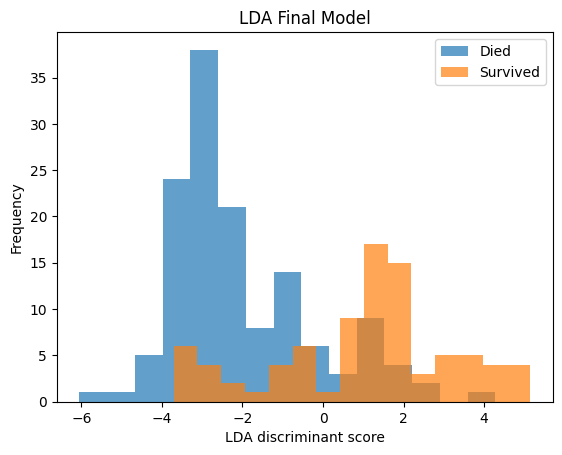

In [76]:
# -------------------------
# 8) Final feature-tuned model: fit on TRAIN, evaluate on TEST
# -------------------------
final_features = importance_best_tuned.head(best_k).index
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(solver="lsqr", shrinkage=0.1))
])

final_model.fit(X_train[final_features], y_train)
y_pred_final = final_model.predict(X_test[final_features])

print("\n=== Final Feature-Tuned LDA (TEST holdout) ===")
print("Using top-k features:", best_k)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Test MSE:      {mean_squared_error(y_test, y_pred_final):.4f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_final))

coefs_best_features = []
for tr_idx, va_idx in cv.split(X_train, y_train):
    X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    m = clone(final_model)
    m.fit(X_tr, y_tr)
    coefs_best_features.append(m.named_steps["lda"].coef_.ravel())

coefs_best_features = np.vstack(coefs_best_features)

importance_final = pd.DataFrame({
    "mean_coef": np.mean(coefs_best_features, axis=0),
    "mean_abs_coef": np.mean(np.abs(coefs_best_features), axis=0),
    "std_abs_coef":  np.std(np.abs(coefs_best_features), axis=0)
}, index=X_train.columns).sort_values("mean_abs_coef", ascending=False)

print("\n=== Feature Importance (LDA Final Model) ===")
print(importance_final)

lda_scores_final= final_model.decision_function(X_test[final_features])

plt.figure()
plt.hist(lda_scores_final[y_test == 0], bins=15, alpha=0.7, label="Died")
plt.hist(lda_scores_final[y_test == 1], bins=15, alpha=0.7, label="Survived")
plt.xlabel("LDA discriminant score")
plt.ylabel("Frequency")
plt.title("LDA Final Model")
plt.legend()
plt.show()

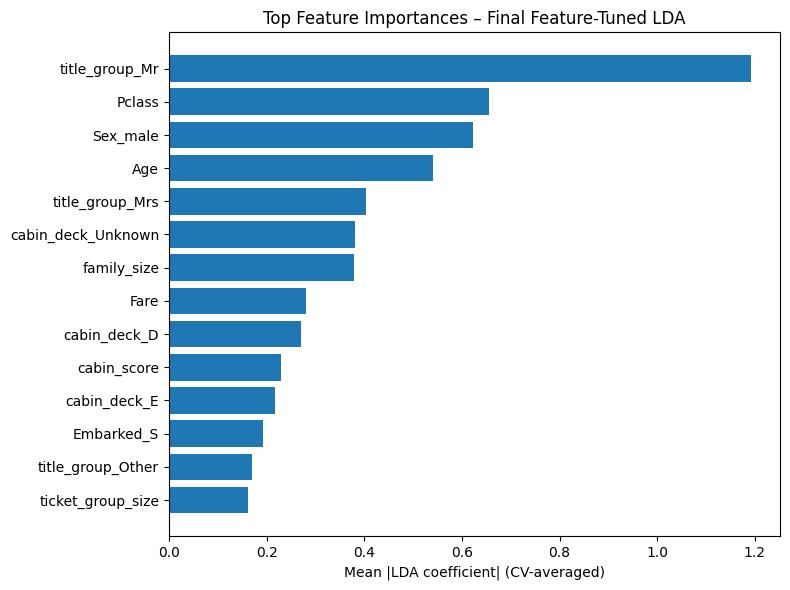

In [78]:
top_n = min(15, len(final_features))
top = importance_final.head(top_n).sort_values("mean_abs_coef")

plt.figure(figsize=(8, 6))
plt.barh(top.index, top["mean_abs_coef"])
plt.xlabel("Mean |LDA coefficient| (CV-averaged)")
plt.title("Top Feature Importances – Final Feature-Tuned LDA")
plt.tight_layout()
plt.show()

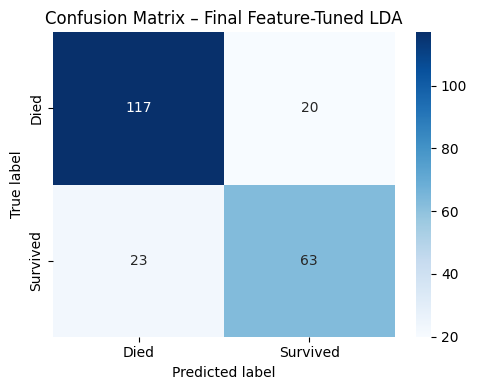

In [80]:
cm_final = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_final,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Died", "Survived"],
    yticklabels=["Died", "Survived"]
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Final Feature-Tuned LDA")
plt.tight_layout()
plt.show()